In [2]:
import subprocess
import random
import numpy as np
import time
import os
import csv
import matplotlib.pyplot as plt
import matplotlib
import glob
import getpass
from pathlib import Path

In [3]:
cpu_model = None
while not cpu_model:
    cpu_model = input('Qual é o seu processador?').replace(' ', '_')
Path(f'./results/processors/{cpu_model}').mkdir(parents=True, exist_ok=True)

Qual é o seu processador? i7 2600


In [43]:
def generateArray(size, seed=None):
    random.seed(seed)
    if os.path.isfile(f"data/array-{size}.txt"): return
    with open(f"data/array-{size}.txt", "w") as f:
        for i in np.arange(size, 0, -1, dtype=np.int64): f.write(str(i) + ' ')

def compile(source_file):
    print(*["g++", "./lib/System.cpp", "./lib/App.hpp", f'algorithms/{source_file}', "-o", f'./bin/{source_file[:-4]}', "-lpapi", "-O0", "-I./lib/", "-I.", "-lm"])
    start_time = time.time()
    process = subprocess.Popen(["g++", "./lib/System.cpp", f'algorithms/{source_file}', "-o", f'./bin/{source_file[:-4]}', "-lpapi", "-O0", "-I./lib/", "-I.", "-lm"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    end_time = (time.time() - start_time)
    print(f"Compile time: {end_time}s")
    if stderr:
        print("Error:\n" + stderr.decode("utf-8"))
        return False
    else:
        print("Compiled with success")
        return True

def run(source_file, args, array_size, log=False):
    start_time = time.time()
    process = subprocess.Popen(["./bin/"+source_file[:-4], *args.split()], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    end_time = (time.time() - start_time)
    if log: print(f"{array_size} run time: {end_time}s")
    if stderr:
        if log:
            print("Error:\n" + stderr.decode("utf-8"))
        return False
    else:
        if log: 
            print("Runned with success")
            print('stdout:\n' + stdout.decode("utf-8"))
        return True

def plotData(algorithm):
    processor_list = np.array(getProcessorList())
#     fig, axs = plt.subplots(2, 3, figsize=(24, 9), sharey='row')
    fig =  plt.figure(figsize=(24, 12))
    G = matplotlib.gridspec.GridSpec(3,3)
    ax0 = plt.subplot(G[0,0])
    ax1 = plt.subplot(G[0,1], sharey=ax0)
    ax2 = plt.subplot(G[0,2], sharey=ax0)
    ax3 = plt.subplot(G[1,:], sharex=ax0)
    ax4 = plt.subplot(G[2,:], sharex=ax0)
#     print(axs)
#     if axs.shape == (2,):
#         axs = np.reshape(axs, (1, axs.shape[0]))
    for i, procesor in enumerate(processor_list):
        print(procesor)
        filename = f'./results/processors/{procesor}/result_{algorithm}.txt'
        with open(filename) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=';')
            line_count = 0
            array_size = []
            time_spent = []
            PAPI_L1_TCM = []
            PAPI_L2_TCM = []
            PAPI_L3_TCM = []
            DATA_BYTES = []
            NUM_INSTRUCTIONS = []
            PAPI_TOT_INS = []
            theorical_instructions_per_second = []
            papi_instructions_per_second = []
            for row in csv_reader:
                if line_count == 0:
                    print(f'Column names are {", ".join(row)}')
                    line_count += 1
                else:
                    array_size.append(int(row[0]))
                    time_spent.append(float(row[1]))
                    PAPI_L1_TCM.append(int(row[2]))
                    PAPI_L2_TCM.append(int(row[3]))
                    PAPI_L3_TCM.append(int(row[4]))
                    DATA_BYTES.append(int(row[5]))
                    NUM_INSTRUCTIONS.append(int(row[6]))
                    PAPI_TOT_INS.append(int(row[7]))
                    papi_instructions_per_second.append(int(row[7]) / float(row[1]))
                    theorical_instructions_per_second.append(int(row[6]) / float(row[1]))
                    line_count += 1
                    
            ax0.plot(DATA_BYTES, PAPI_L1_TCM, label=procesor.replace('_', ' '))
            ax0.set_xlabel('Bytes')
            ax0.set_ylabel('L1 MISS')
            ax0.set_title('Bytes x L1 Miss')
            ax0.margins(x=0.005, y=0.01)
            ax0.grid()
            ax0.legend()
            ax0.set_yscale('log', basey=10)
            ax0.set_xscale('log', basex=2)
                    
            ax1.plot(DATA_BYTES, PAPI_L2_TCM, label=procesor.replace('_', ' '))
            ax1.set_xlabel('Bytes')
            ax1.set_ylabel('L2 MISS')
            ax1.set_title('Bytes x L2 Miss')
            ax1.margins(x=0.005, y=0.01)
            ax1.grid()
            ax1.legend()
            ax1.set_yscale('log', basey=10)
            ax1.set_xscale('log', basex=2)
                    
            ax2.plot(DATA_BYTES, PAPI_L3_TCM, label=procesor.replace('_', ' '))
            ax2.set_xlabel('Bytes')
            ax2.set_ylabel('L3 MISS')
            ax2.set_title('Bytes x L3 Miss')
            ax2.margins(x=0.005, y=0.01)
            ax2.grid()
            ax2.legend()
            ax2.set_yscale('log', basey=10)
            ax2.set_xscale('log', basex=2)

            
            ax3.plot(DATA_BYTES, theorical_instructions_per_second, label=procesor.replace('_', ' '))
            ax3.set_xlabel('Bytes')
            ax3.set_ylabel('Instructions/s')
            ax3.set_title('Bytes x Instructions/s')
            ax3.margins(x=0.005, y=0.01)
            ax3.grid()
            ax3.legend()
            ax3.set_yscale('log', basey=10)
            ax3.set_xscale('linear')

            
            ax4.plot(DATA_BYTES, time_spent, label=procesor.replace('_', ' '))
            ax4.set_xlabel('Bytes')
            ax4.set_ylabel('Seconds')
            ax4.set_title('Bytes x Seconds')
            ax4.margins(x=0.005, y=0.01)
            ax4.grid()
            ax4.legend()
#             ax4.set_yscale('log', basey=10)
            ax4.set_yscale('linear')
            ax4.set_xscale('linear')
            
            
#             axs[0][0].set_xticks(np.arange(min(DATA_BYTES), max(DATA_BYTES)+1024, min(DATA_BYTES)*5))
#             axs[0][1].set_xticks(np.arange(min(DATA_BYTES), max(DATA_BYTES)+1024, min(DATA_BYTES)*5))
#             axs[0][2].set_xticks(np.arange(min(DATA_BYTES), max(DATA_BYTES)+1024, min(DATA_BYTES)*5))
            
#             if len(PAPI_TOT_INS) > 0:
#                 axs[1].plot(DATA_BYTES, theorical_instructions_per_second, label=procesor.replace('_', ' '))
#                 axs[1].legend()
            
            
#     plt.legend()

    plt.subplots_adjust(hspace=0.4)
    fig.suptitle(algorithm.replace('_', ' ').title(), fontsize=16)
    plt.show()
    fig.savefig(f'./charts/{algorithm}.png', bbox_inches = 'tight', dpi=300)

def generateResultFile(filename, headers):
    data_filename = f'results/processors/{cpu_model}/result_{filename[:-4]}.txt'
    if os.path.exists(data_filename):
        os.remove(data_filename)
    with open(data_filename, 'w') as data_file:
        data_file.write(headers)

def clean_data_files():
    files = glob.glob('data/*')
    print("Cleaning data/ ~")
    for f in files:
        os.remove(f)

def enableKernelEvents():
    with open("/proc/sys/kernel/perf_event_paranoid", "r") as f:
        r = f.readline().strip()
        print('/proc/sys/kernel/perf_event_paranoid -> ' + r)
        if r != '0':
            print('Type your password to unlock some kernel events. REQUIRED')
            command = "sudo -S sh -c 'echo 0 >/proc/sys/kernel/perf_event_paranoid'"
            password = getpass.getpass()
            aa = os.system('echo %s | %s' % (password, command))
            password = None
            enableKernelEvents()
        else:
            print("Success")

def getProcessorList():
    dirlist = []
    for filename in os.listdir("./results/processors/"):
        if os.path.isdir(os.path.join("./results/processors/",filename)):
            dirlist.append(filename)
    if '.ipynb_checkpoints' in dirlist:
        dirlist.remove('.ipynb_checkpoints')
    return dirlist

In [4]:
enableKernelEvents()

/proc/sys/kernel/perf_event_paranoid -> 0
Success


i7_8550U
Column names are array_size, time_spent(s), PAPI_L1_TCM, PAPI_L2_TCM, PAPI_L3_TCM, DATA_BYTES, NUM_INSTRUCTIONS, PAPI_TOT_INS
i7_2600
Column names are array_size, time_spent(s), PAPI_L1_TCM, PAPI_L2_TCM, PAPI_L3_TCM, DATA_BYTES, NUM_INSTRUCTIONS, PAPI_TOT_INS
i5_5200U
Column names are array_size, time_spent(s), PAPI_L1_TCM, PAPI_L2_TCM, PAPI_L3_TCM, DATA_BYTES, NUM_INSTRUCTIONS, PAPI_TOT_INS
i7_2600k_@4.4GHz
Column names are array_size, time_spent(s), PAPI_L1_TCM, PAPI_L2_TCM, PAPI_L3_TCM, DATA_BYTES, NUM_INSTRUCTIONS, PAPI_TOT_INS


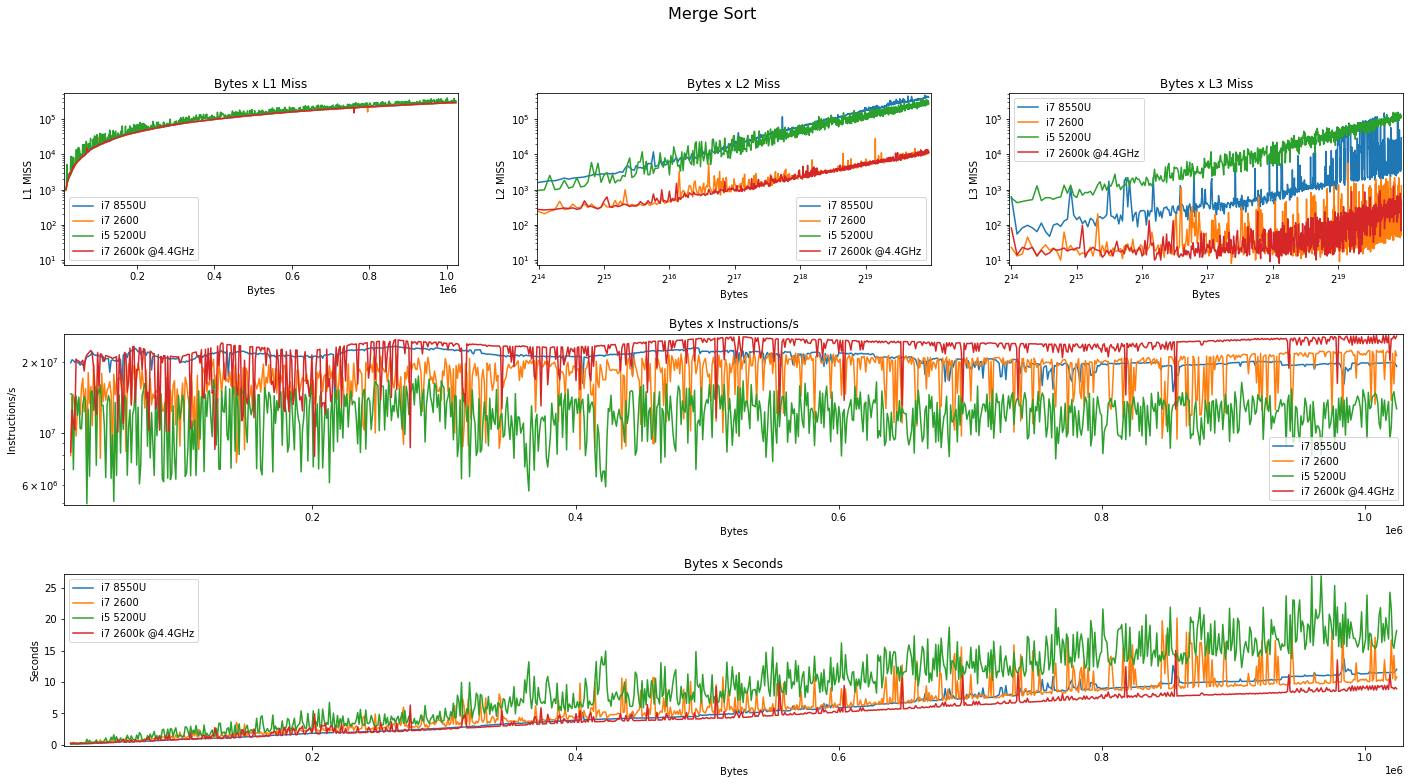

In [44]:
filename = 'merge_sort.cpp'
plotData(filename[:-4])

i7_8550U
Column names are array_size, time_spent(s), PAPI_L1_TCM, PAPI_L2_TCM, PAPI_L3_TCM, DATA_BYTES, NUM_INSTRUCTIONS, PAPI_TOT_INS
i7_2600
Column names are array_size, time_spent(s), PAPI_L1_TCM, PAPI_L2_TCM, PAPI_L3_TCM, DATA_BYTES, NUM_INSTRUCTIONS, PAPI_TOT_INS
i5_5200U
Column names are array_size, time_spent(s), PAPI_L1_TCM, PAPI_L2_TCM, PAPI_L3_TCM, DATA_BYTES, NUM_INSTRUCTIONS, PAPI_TOT_INS
i7_2600k_@4.4GHz
Column names are array_size, time_spent(s), PAPI_L1_TCM, PAPI_L2_TCM, PAPI_L3_TCM, DATA_BYTES, NUM_INSTRUCTIONS, PAPI_TOT_INS


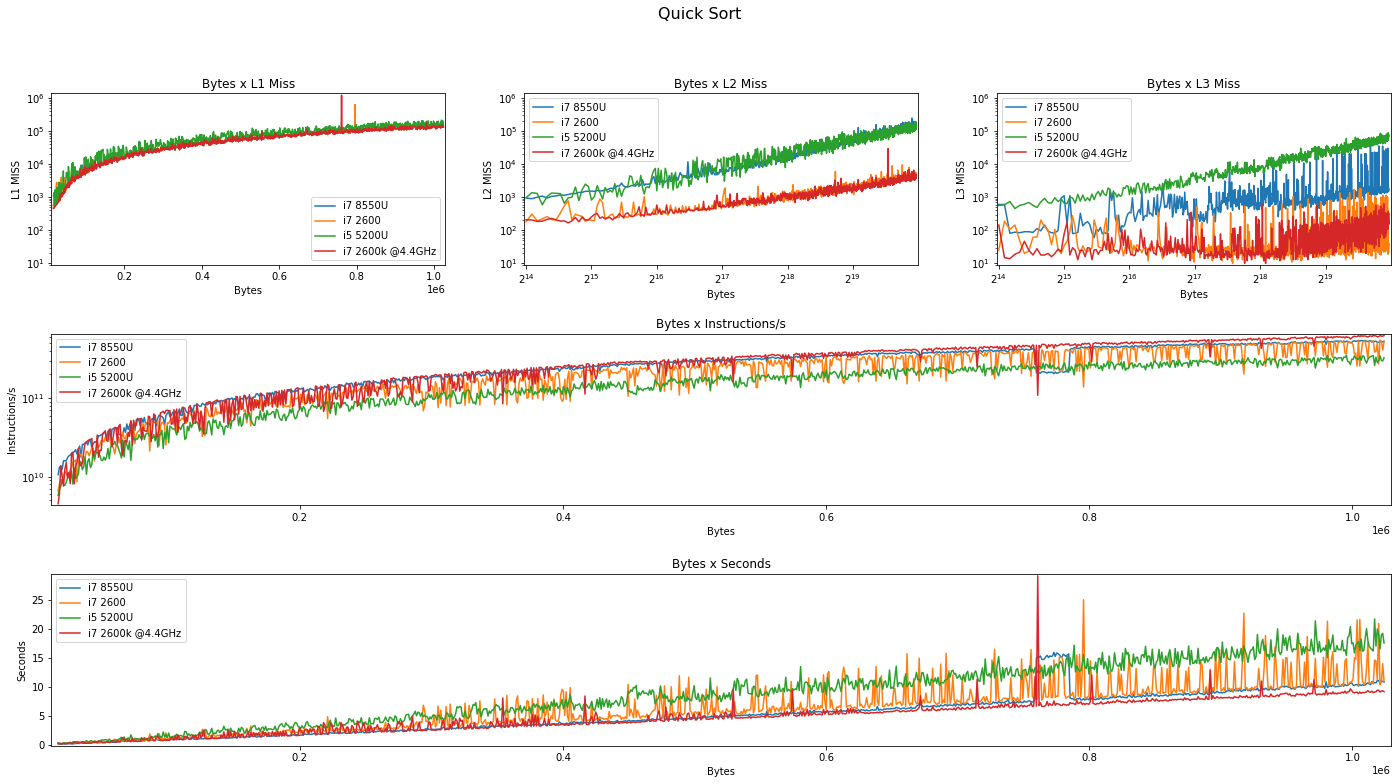

In [45]:
filename = 'quick_sort.cpp'
plotData(filename[:-4])

g++ ./lib/System.cpp ./lib/App.hpp algorithms/quick_sort.cpp -o ./bin/quick_sort -lpapi -O0 -I./lib/ -I. -lm
Compile time: 0.6754922866821289s
Compiled with success
i7_2600
Column names are array_size, time_spent(s), PAPI_L1_TCM, PAPI_L2_TCM, PAPI_L3_TCM, DATA_BYTES, NUM_INSTRUCTIONS, PAPI_TOT_INS
i7_2600k_@4.4GHz
Column names are array_size, time_spent(s), PAPI_L1_TCM, PAPI_L2_TCM, PAPI_L3_TCM, DATA_BYTES, NUM_INSTRUCTIONS, PAPI_TOT_INS


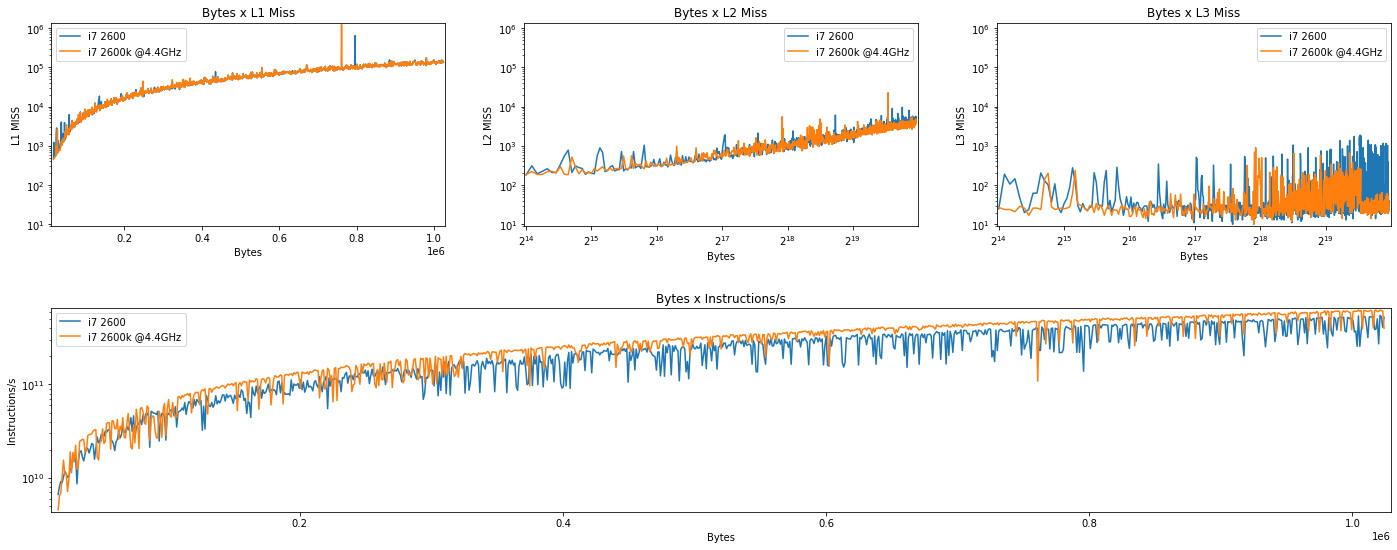

In [10]:
filename = 'quick_sort.cpp'
if compile(filename):
    generateResultFile(filename, 'array_size;time_spent(s);PAPI_L1_TCM;PAPI_L2_TCM;PAPI_L3_TCM;DATA_BYTES;NUM_INSTRUCTIONS;PAPI_TOT_INS\n')

    for array_size in np.arange(2048, 128000+1, 128):
        generateArray(size=array_size)
        run(filename, f'./data/array-{array_size}.txt {array_size} {cpu_model}', array_size, log=False);
    
    plotData(filename[:-4])

g++ ./lib/System.cpp ./lib/App.hpp algorithms/merge_sort.cpp -o ./bin/merge_sort -lpapi -O0 -I./lib/ -I. -lm
Compile time: 0.7512364387512207s
Compiled with success
i7_2600
Column names are array_size, time_spent(s), PAPI_L1_TCM, PAPI_L2_TCM, PAPI_L3_TCM, DATA_BYTES, NUM_INSTRUCTIONS, PAPI_TOT_INS
i7_2600k_@4.4GHz
Column names are array_size, time_spent(s), PAPI_L1_TCM, PAPI_L2_TCM, PAPI_L3_TCM, DATA_BYTES, NUM_INSTRUCTIONS, PAPI_TOT_INS


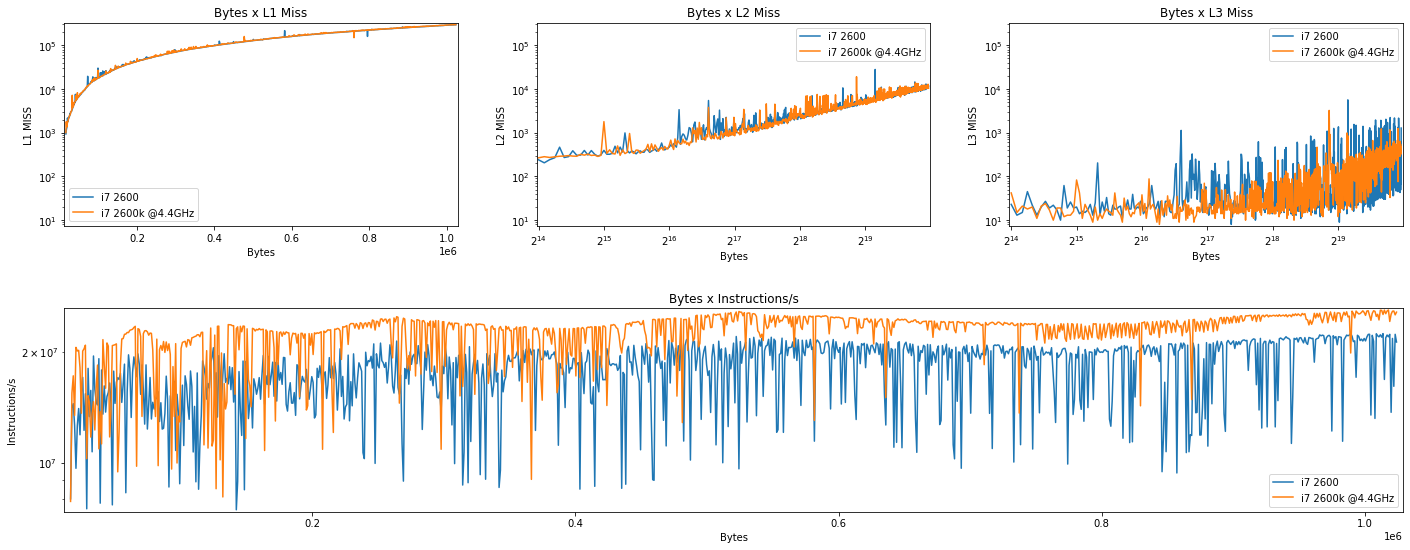

In [11]:
filename = 'merge_sort.cpp'
if compile(filename):
    generateResultFile(filename, 'array_size;time_spent(s);PAPI_L1_TCM;PAPI_L2_TCM;PAPI_L3_TCM;DATA_BYTES;NUM_INSTRUCTIONS;PAPI_TOT_INS\n')

    for array_size in np.arange(2048, 128000+1, 128):
        generateArray(size=array_size)
        run(filename, f'./data/array-{array_size}.txt {array_size} {cpu_model}', array_size, log=False);
    
    plotData(filename[:-4])